In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import GridSearchCV, KFold
import catboost as cb

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 10})

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

По сводной таблице с данными видно, что выбиваются из нормы максимальные и минимальные значения Square, LifeSquare и KitchenSquare. В столбце HouseFloor также настораживают мин. и макс. значения, которые в дальнейшем лучше обработать. В HouseYear также необходимо избавиться от неадекватных значений.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Анализ данных

### Целевая переменная

Проанализируем цену недвижимости в датасете - построим график распределения цены.

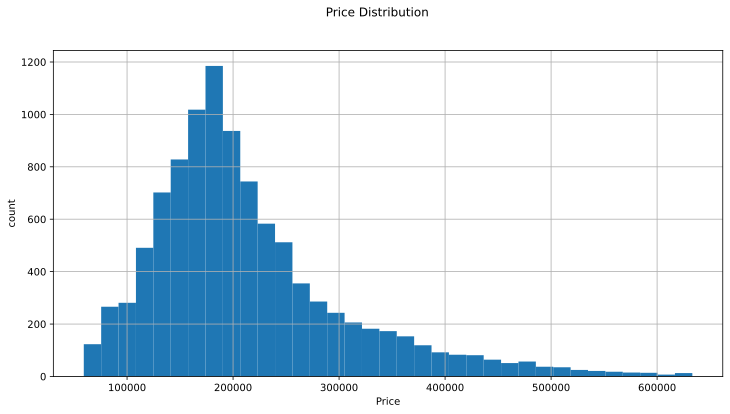

In [7]:
plt.figure(figsize = (12, 6))

df['Price'].hist(density=False, bins=35)
plt.ylabel('count')
plt.xlabel('Price')

plt.suptitle('Price Distribution')
plt.show()

По графику видно, что наибольшее количество квартир находится в среднем ценовом диапазоне от 110000 до 250000. Количество предлагаемых квартир на рынке падает с увеличением цены. По минимальным ценам также квартир значительно меньше.

### Номинативные переменные

Из информации о датасете видим, что столбцы "Ecology_2", "Ecology_3" и "Shops_2" имеют тип object. Проверим содержание данных столбцов с помощью метода value_counts().

In [8]:
df["Ecology_2"].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [9]:
df["Ecology_3"].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [10]:
df["Shops_2"].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Также выведем содержание столбца "DistrictId":

In [11]:
df["DistrictId"].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

Нумерация по районам относится к категориальным признакам, поэтому далее DistrictId выразим через число квартир в каждом районе.

#### Выведем гистограммы распределения числовых признаков

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

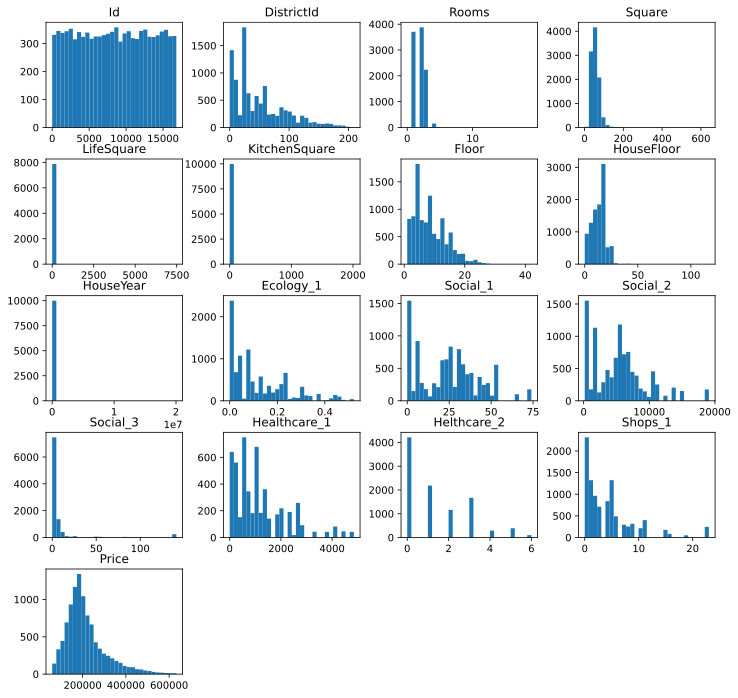

In [12]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12, 12), bins=30, grid=False)

Судя по гистограммам и сводной таблице describe в столбцах Rooms, Square, LifeSquare, KitchenSquare, HouseFloor имеются выбросы. Построим графики зависимостей цены от данных столбцов.

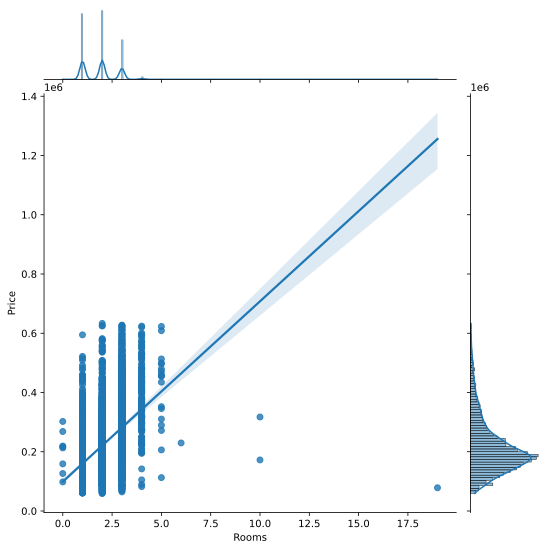

In [13]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Будем считать все варианты с количеством комнат больше 5 и равным 0 выбросами. Несмотря на то, что такие варианты вполне реальны, их количество очень мало, поэтому для предсказаний они могут только мешать.

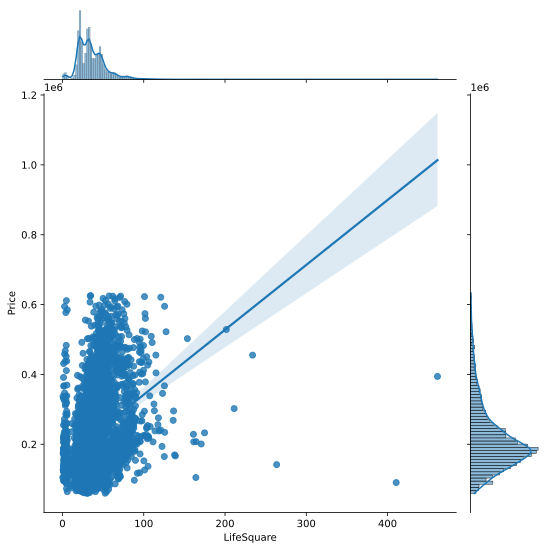

In [14]:
grid = sns.jointplot(df.loc[df['LifeSquare'] < 500, 'LifeSquare'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

В данных жилой площади LifeSquare присутствуют выбросы. Для Square характер зависимости схож. В дальнейшем ограничим значения LifeSquare и Square величиной 200 сверху. Снизу Square ограничим значением 15, LifeSquare - 10.

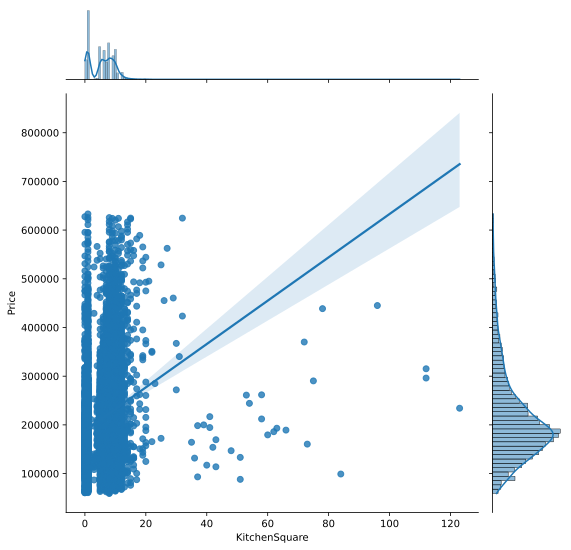

In [15]:
grid = sns.jointplot(df.loc[df['KitchenSquare'] < 200, 'KitchenSquare'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Для KitchenSquare отфильтруем значения выше 25 и ниже 5.

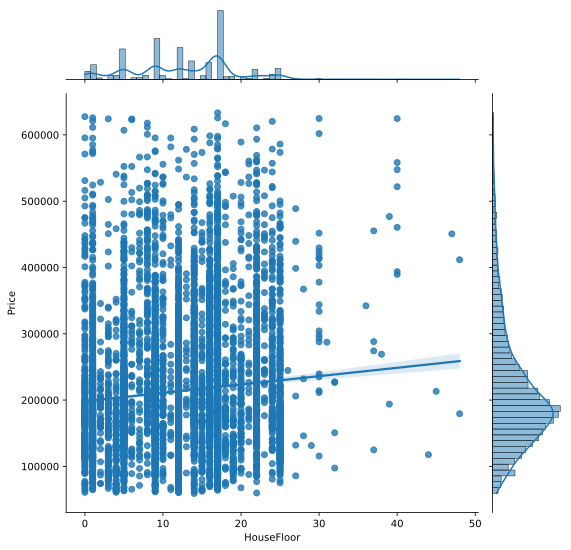

In [16]:
grid = sns.jointplot(df.loc[df['HouseFloor'] < 60, 'HouseFloor'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Для HouseFloor отбросим все значения выше 25 этажа.

## Обработка выбросов

In [17]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.lifesquare_by_rooms = None
    
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан и жилой площади в зависимости от количества комнат
        self.medians = X.median()
        self.lifesquare_by_rooms = X.groupby("Rooms", as_index=False).agg({"LifeSquare": "median"})\
                                             .rename(columns={'LifeSquare':'MedLifeSquareByRooms'})
        
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = 5
        
        # Square      
        X.loc[X['Square'] < 15, 'Square'] = 15
        X.loc[X['Square'] > 200, 'Square'] = 200
        
        # LifeSquare
        X = X.merge(self.lifesquare_by_rooms, on="Rooms", how='left')
        X['LifeSquare'].fillna(X['MedLifeSquareByRooms'], inplace=True)
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = 10
        X.loc[X['LifeSquare'] > 200, 'LifeSquare'] = 200
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        X.loc[X['KitchenSquare'] > 25, 'KitchenSquare'] = 25
        
        # HouseFloor&Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        X.loc[X['HouseFloor'] > 30, 'HouseFloor'] = 30
        
        condition = X['Floor'] > X['HouseFloor']
        X.loc[condition, 'Floor'] = X.loc[condition, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        X.loc[X['Floor'] > 30, 'Floor'] = 30
        
        # HouseYear
        current_year = datetime.now().year
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Генерация новых признаков

In [18]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.district_size = None
        self.med_price_per_meter_by_district = None
        self.med_price_per_meter_by_district_rooms = None
        self.med_price_per_meter = None
        self.med_price_per_meter_by_healthcare2 = None
        self.med_social2_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        ## Выразим DistrictID через количество квартир в каждом районе и назовем данный столбец DistrictSize.        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            ### Найдем медиану цены за квадратный метр в зависимости от района и количества комнат.
            df["Price_per_meter"] = df["Price"] / df["Square"]
            self.med_price_per_meter_by_district_rooms = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price_per_meter':'median'})\
                                            .rename(columns={'Price_per_meter':'MedPricePerMeterByDistrictRooms'})
            
            ### Для нового числа комнат, которые могут появиться в тестовом датасете, рассчитаем медиану цены за кв. метр в зависимости от района.
            self.med_price_per_meter_by_district = df.groupby("DistrictId", as_index=False).agg({"Price_per_meter": "median"})\
                 .rename(columns={'Price_per_meter':'MedPricePerMeterByDistrict'})
            
            ### Для новых районов, которые могут появиться в тестовом датасете, рассчитаем медиану цены за кв. метр.
            self.med_price_per_meter = df["Price_per_meter"].median()
            
            ## Helthcare_2:    
            ### Средняя цена за кв. метр для разных значений Helthcare_2:
            self.med_price_per_meter_by_healthcare2 = df.groupby("Helthcare_2", as_index=False).agg({"Price_per_meter": "median"})\
                 .rename(columns={'Price_per_meter':'MedPricePerMeterByHealthcare2'}) 
            
        ## Social_2
        ### Медиана параметра Social_2 по районам:
        self.med_social2_by_district = df.groupby("DistrictId", as_index=False).agg({"Social_2": "median"})\
             .rename(columns={'Social_2':'Social_2_median'})
    
    def transform(self, X):
        
        # Binary features
        ## Столбцы типа object ("Ecology_2", "Ecology_3" и "Shops_2") приведем к dummy-переменным.
        X = pd.get_dummies(X)
        
        # DistrictId
        ## Присоединим столбец DistrictSize к датасету и предусмотрим заполнение пустых ячеек в случае новых районов.
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(1, inplace=True)
        
        # Target encoding
        ## Присоединим столбец MedPricePerMeterByDistrictRooms к датасету. При этом предусмотрим появление нового количества комнат и\
        ## новых районов.
        if self.med_price_per_meter_by_district_rooms is not None:
            X = X.merge(self.med_price_per_meter_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
            X = X.merge(self.med_price_per_meter_by_district, on='DistrictId', how='left')
            X['MedPricePerMeterByDistrict'].fillna(self.med_price_per_meter, inplace=True)
            X['MedPricePerMeterByDistrictRooms'].fillna(X['MedPricePerMeterByDistrict'], inplace=True)
            X = X.drop('MedPricePerMeterByDistrict', axis=1)
        
        ## Присоединим столбец MedPricePerMeterByHealthcare2 к датасету:
        if self.med_price_per_meter_by_healthcare2 is not None:
            X = X.merge(self.med_price_per_meter_by_healthcare2, on='Helthcare_2', how='left')
        
        ## Присоединим столбец Social_2_median к датасету:    
        if self.med_social2_by_district is not None:
            X = X.merge(self.med_social2_by_district, on='DistrictId', how='left')
         
        return X    

## Отбор признаков

In [19]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [20]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

new_feature_names = ['MedPricePerMeterByDistrictRooms', 'DistrictSize', 'MedPricePerMeterByHealthcare2', 'Social_2_median']

target_name = 'Price'

## Разбиение на train и test

In [21]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [22]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train = X.copy()
y_train = y
X_valid = X.copy()
y_valid = y

In [23]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((10000, 20), (10000, 20), (5000, 20))

In [24]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'MedLifeSquareByRooms']

In [25]:
features_gen = FeatureGenerator()
features_gen.fit(X, y)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((10000, 27), (10000, 27), (5000, 27))

In [26]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.shape, X_valid.shape, test_df.shape

((10000, 24), (10000, 24), (5000, 24))

## Построение модели

In [27]:
# model_cb = cb.CatBoostRegressor(silent=True, eval_metric='R2', random_state=42)

# parameters = {'iterations': [400, 800, 1000, 1100],
#         'learning_rate': [0.01, 0.03, 0.1],
#         'depth': [4, 6, 8, 10],
#         'l2_leaf_reg': [0.1, 0.2, 0.5, 1, 3, 5, 7, 9]}

# grid = GridSearchCV(estimator=model_cb, param_grid = parameters, cv = 3, n_jobs=-1)
# grid.fit(X_train, y_train)

In [28]:
# grid.best_params_

In [29]:
# y_pred_train = grid.predict(X_train)
# R2_train = r2_score(y_train, y_pred_train)
# print(R2_train)

# pred = grid.predict(X_valid)
# r2 = r2_score(y_valid, pred)
# print("Testing performance")
# print('R2: {}'.format(r2))

#### C помощью grid_search подбираем лучшие параметры, которые подаем в модель CatBoostRegressor:

In [30]:
cb_temp = cb.CatBoostRegressor(iterations=800, learning_rate=0.03, depth=8, l2_leaf_reg=1, eval_metric='R2', random_state=42)
cb_temp.fit(X_train, y_train)

0:	learn: 0.0383909	total: 60.4ms	remaining: 48.2s
1:	learn: 0.0745789	total: 63.3ms	remaining: 25.2s
2:	learn: 0.1093977	total: 66.3ms	remaining: 17.6s
3:	learn: 0.1414536	total: 69.2ms	remaining: 13.8s
4:	learn: 0.1717858	total: 72.2ms	remaining: 11.5s
5:	learn: 0.2009067	total: 75.1ms	remaining: 9.94s
6:	learn: 0.2288454	total: 78ms	remaining: 8.84s
7:	learn: 0.2550495	total: 81ms	remaining: 8.02s
8:	learn: 0.2796437	total: 83.6ms	remaining: 7.35s
9:	learn: 0.3032314	total: 86.6ms	remaining: 6.84s
10:	learn: 0.3250251	total: 89.5ms	remaining: 6.42s
11:	learn: 0.3466183	total: 92.4ms	remaining: 6.07s
12:	learn: 0.3670486	total: 95.3ms	remaining: 5.77s
13:	learn: 0.3863242	total: 98.2ms	remaining: 5.51s
14:	learn: 0.4039920	total: 101ms	remaining: 5.3s
15:	learn: 0.4208028	total: 104ms	remaining: 5.11s
16:	learn: 0.4359622	total: 107ms	remaining: 4.93s
17:	learn: 0.4515450	total: 110ms	remaining: 4.77s
18:	learn: 0.4662306	total: 113ms	remaining: 4.62s
19:	learn: 0.4807137	total: 116m

208:	learn: 0.8200967	total: 632ms	remaining: 1.79s
209:	learn: 0.8203758	total: 634ms	remaining: 1.78s
210:	learn: 0.8206940	total: 637ms	remaining: 1.78s
211:	learn: 0.8208754	total: 639ms	remaining: 1.77s
212:	learn: 0.8211402	total: 642ms	remaining: 1.77s
213:	learn: 0.8214012	total: 644ms	remaining: 1.76s
214:	learn: 0.8215394	total: 647ms	remaining: 1.76s
215:	learn: 0.8217845	total: 650ms	remaining: 1.76s
216:	learn: 0.8220078	total: 652ms	remaining: 1.75s
217:	learn: 0.8222119	total: 655ms	remaining: 1.75s
218:	learn: 0.8224686	total: 658ms	remaining: 1.75s
219:	learn: 0.8225688	total: 660ms	remaining: 1.74s
220:	learn: 0.8228100	total: 663ms	remaining: 1.74s
221:	learn: 0.8231082	total: 665ms	remaining: 1.73s
222:	learn: 0.8233220	total: 668ms	remaining: 1.73s
223:	learn: 0.8235784	total: 671ms	remaining: 1.72s
224:	learn: 0.8237725	total: 673ms	remaining: 1.72s
225:	learn: 0.8240390	total: 675ms	remaining: 1.72s
226:	learn: 0.8241577	total: 678ms	remaining: 1.71s
227:	learn: 

425:	learn: 0.8614473	total: 1.2s	remaining: 1.06s
426:	learn: 0.8615716	total: 1.21s	remaining: 1.05s
427:	learn: 0.8617119	total: 1.21s	remaining: 1.05s
428:	learn: 0.8618779	total: 1.21s	remaining: 1.05s
429:	learn: 0.8620005	total: 1.21s	remaining: 1.04s
430:	learn: 0.8622087	total: 1.22s	remaining: 1.04s
431:	learn: 0.8623066	total: 1.22s	remaining: 1.04s
432:	learn: 0.8624259	total: 1.22s	remaining: 1.04s
433:	learn: 0.8626663	total: 1.22s	remaining: 1.03s
434:	learn: 0.8627627	total: 1.23s	remaining: 1.03s
435:	learn: 0.8628425	total: 1.23s	remaining: 1.03s
436:	learn: 0.8629744	total: 1.23s	remaining: 1.02s
437:	learn: 0.8630908	total: 1.23s	remaining: 1.02s
438:	learn: 0.8631856	total: 1.24s	remaining: 1.02s
439:	learn: 0.8633569	total: 1.24s	remaining: 1.01s
440:	learn: 0.8635516	total: 1.24s	remaining: 1.01s
441:	learn: 0.8636490	total: 1.25s	remaining: 1.01s
442:	learn: 0.8637853	total: 1.25s	remaining: 1s
443:	learn: 0.8639477	total: 1.25s	remaining: 1s
444:	learn: 0.86410

637:	learn: 0.8871996	total: 1.77s	remaining: 451ms
638:	learn: 0.8872755	total: 1.78s	remaining: 448ms
639:	learn: 0.8873724	total: 1.78s	remaining: 445ms
640:	learn: 0.8874839	total: 1.78s	remaining: 442ms
641:	learn: 0.8875775	total: 1.79s	remaining: 440ms
642:	learn: 0.8876733	total: 1.79s	remaining: 437ms
643:	learn: 0.8877574	total: 1.79s	remaining: 434ms
644:	learn: 0.8878325	total: 1.79s	remaining: 431ms
645:	learn: 0.8879417	total: 1.79s	remaining: 428ms
646:	learn: 0.8880450	total: 1.8s	remaining: 425ms
647:	learn: 0.8881219	total: 1.8s	remaining: 422ms
648:	learn: 0.8882872	total: 1.8s	remaining: 420ms
649:	learn: 0.8884240	total: 1.81s	remaining: 417ms
650:	learn: 0.8885466	total: 1.81s	remaining: 414ms
651:	learn: 0.8886269	total: 1.81s	remaining: 411ms
652:	learn: 0.8886896	total: 1.81s	remaining: 408ms
653:	learn: 0.8888252	total: 1.82s	remaining: 405ms
654:	learn: 0.8889120	total: 1.82s	remaining: 403ms
655:	learn: 0.8890210	total: 1.82s	remaining: 400ms
656:	learn: 0.8

In [31]:
y_pred_train = cb_temp.predict(X_train)
R2_train = r2_score(y_train, y_pred_train)
print(R2_train)

pred = cb_temp.predict(X_valid)
r2 = r2_score(y_valid, pred)
print("Testing performance")
print('R2: {}'.format(r2))

0.9006971285565991
Testing performance
R2: 0.8992032098379209


#### Выведем распределение признаков по важности для модели:

Text(0.5, 0, 'CatBoost Feature Importance')

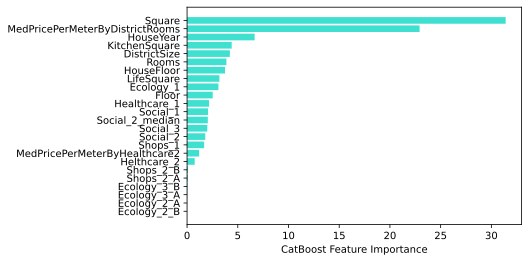

In [32]:
sorted_feature_importance = cb_temp.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cb_temp.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

## Сохранение данных с предсказаниями по тестовому датасету

In [33]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [34]:
predictions = cb_temp.predict(test_df)
predictions

array([168613.58685988, 118821.94462403, 149124.71675344, ...,
       148099.50327794, 190029.37952501, 272815.75815436])

In [35]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  168613.586860
1  5925  118821.944624
2   960  149124.716753
3  3848  100648.842264
4   746  170743.249973

In [36]:
# submit.to_csv('cb_classes_3_soc2_submit.csv', index=False)